In [1]:
import numpy as np
import pandas as pd
import json
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [2]:
# расчет метрик
def compute_metrics(fitted_model, X_test, y_test):
    metrics = {}
    y_pred = fitted_model.predict(X_test)
    if hasattr(fitted_model, 'predict_proba'):
        y_pred_proba = fitted_model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None
    model_name = fitted_model.__class__.__name__
    metrics['model'] = model_name if model_name != 'Pipeline' else 'LogisticRegression'
    metrics['accuracy'] = float(accuracy_score(y_test, y_pred))
    metrics['precision'] = float(precision_score(y_test, y_pred))
    metrics['recall'] = float(recall_score(y_test, y_pred))
    metrics['f1-score'] = float(f1_score(y_test, y_pred))
    if y_pred_proba is not None:
        try:
            metrics['roc auc'] = float(roc_auc_score(y_test, y_pred_proba))
            metrics['average precision'] = float(average_precision_score(y_test, y_pred_proba))
        except Exception:
            metrics['roc auc'] = None
            metrics['average precision'] = None
    else:
        metrics['roc auc'] = None
        metrics['average precision'] = None
    return metrics

In [30]:
df = pd.read_csv('S06-hw-dataset-04.csv')
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float64
 22

In [6]:
with pd.option_context('display.max_columns', None,  
                      'display.width', 1000,      
                      'display.max_rows', 62):
    display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,25000.0,12500.500000,7217.022701,1.000000,6250.750000,12500.500000,18750.250000,25000.000000
f01,25000.0,-0.000386,1.001623,-4.370993,-0.680165,0.001859,0.679702,4.208888
f02,25000.0,-0.004872,0.995606,-4.087073,-0.675100,-0.000247,0.659523,3.984564
f03,25000.0,0.003202,1.004367,-4.103875,-0.675426,0.013272,0.683437,3.793442
f04,25000.0,0.335329,3.207537,-13.249937,-1.750048,0.403483,2.486453,15.288250
f05,25000.0,-0.000563,0.993965,-4.118778,-0.669764,-0.001309,0.672299,4.020733
f06,25000.0,-0.010118,1.002172,-3.895974,-0.674374,-0.005994,0.652629,4.279607
f07,25000.0,0.001182,2.432162,-8.883224,-1.647977,-0.011349,1.658680,9.538525
f08,25000.0,0.957385,1.830223,-8.132548,-0.217260,0.963009,2.167758,9.321099
f09,25000.0,-0.004658,1.013470,-4.068933,-0.688278,0.000414,0.681040,4.261349


In [7]:
sum(df.duplicated())

0

In [8]:
df['target'].value_counts(normalize=True).rename('fraction').to_frame()

,fraction
target,
0,0.9508
1,0.0492


In [9]:
df['target'].value_counts().rename('count').to_frame()

,count
target,
0,23770
1,1230


Набор данных содержит 61 признак, включая id, и 25000 записей. Пропусков и дубликатов нет. Все данные числовые, причем все столбцы, кроме target и id, представлены типом float64.

Классы целевой переменной сильно несбалансированны - 95% против 5%.

In [10]:
random_state = 42

X, y = df.iloc[:, 1:-1], df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

results = []
best_models = {}
search_summaries = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

Разделение данных на признаки и таргет. Все стобцы, кроме id и target, идут в признаки. 

Далее дaнные разделяются на train и test выборки в соотношении 80% на 20%, причем выборки обязательно стратифицированы, так как классы очень сильно несбалансированны. Также для воспроизводимости результатов фиксируется random_state. Далее создается объект для кросс-валидации, причем также подразумевающий стратификацию данных в фолдах по классам.

После этого обучается 5 моделей:
- DummyClassifier
- LogisticRegression (с StandardScaler и подбором гиперпараметров (C и solver))
- DecisionTreeClassifier (с подбором гиперпараметров (max_depth, mean_samples_leaf, cpp_alpha) для регуляризации)
- RandomForestClassifier (также с подбором гиперпараметров (max_depth, max_features, min_samples_leaf))
- HistGradientBoostingClassifier (с подбором learning_rate, max_depth, max_leaf_nodes)
- StackingClassifier, полученный из комбинации моделей с лучшими по перебору параметрами (LogisticRegression, RandomForestClassifier, HistGradientBoostingClassifier)

Все модели, участвующие в подборе гиперпараметров выбирают модель на основе average precision. Эта метрика была выбрана, так как классы очень сильно несбалансированы, а также потому, что avarage precision не завышается на фоне огромного количества негативных примеров (если считать класс 0 негативным, а 1 - положительным), в отличие от roc auc, например. На accuracy в данном случае смотреть также будет бесполезно. Необходим фокус на количестве правильно предсказанных положительных объектах. Поэтому average preision выбрана также потому, что она скорее всего будет вести себя адекватнее и репрезентативнее других.

In [11]:
dummy = DummyClassifier(strategy='stratified', random_state=random_state)
dummy.fit(X_train, y_train)
results.append(compute_metrics(dummy, X_test, y_test))
best_models[results[-1]['model']] = dummy
display(best_models)
results[-1]

{'DummyClassifier': DummyClassifier(random_state=42, strategy='stratified')}

{'model': 'DummyClassifier',
 'accuracy': 0.905,
 'precision': 0.03643724696356275,
 'recall': 0.036585365853658534,
 'f1-score': 0.036511156186612576,
 'roc auc': 0.4932611305498836,
 'average precision': 0.04873307001086205}

In [12]:
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=7000, random_state=random_state))
])

logreg_grid = {'lr__C': [0.1, 1.0, 10.0], 
               'lr__solver': ['lbfgs', 'saga']
              }

logreg_search = GridSearchCV(
    logreg, 
    param_grid=logreg_grid, 
    scoring='average_precision', 
    n_jobs=-1, 
    refit=True, 
    cv=cv, 
    return_train_score=True
)
logreg_search.fit(X_train, y_train)
best_lr = logreg_search.best_estimator_
best_models['LogisticRegression'] = best_lr
search_summaries['LogisticRegression'] = {
    'best_params': logreg_search.best_params_,
    'best_average_precision': float(logreg_search.best_score_)
}
results.append(compute_metrics(best_lr, X_test, y_test))
print(best_models['LogisticRegression'])
display(search_summaries)
results[-1]

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=10.0, max_iter=7000, random_state=42))])


{'LogisticRegression': {'best_params': {'lr__C': 10.0, 'lr__solver': 'lbfgs'},
  'best_average_precision': 0.494023336301691}}

{'model': 'LogisticRegression',
 'accuracy': 0.9632,
 'precision': 0.9078947368421053,
 'recall': 0.2804878048780488,
 'f1-score': 0.42857142857142855,
 'roc auc': 0.8339395836112335,
 'average precision': 0.5088456646193662}

In [13]:
tree = DecisionTreeClassifier(random_state=random_state)
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
tree_grid = [
    {
    'max_depth': [None, 2, 5, 8, 15],
    'min_samples_leaf': [1, 5, 10, 30, 50]
    },
    {
    'ccp_alpha': ccp_alphas[::20]
    }
]

tree_search = GridSearchCV(
    tree, 
    param_grid=tree_grid, 
    scoring='average_precision', 
    n_jobs=-1, 
    refit=True, 
    cv=cv, 
    return_train_score=True
)
tree_search.fit(X_train, y_train)
best_tree = tree_search.best_estimator_
best_models['DecisionTreeClassifier'] = best_tree
search_summaries['DecisionTreeClassifier'] = {
    'best_params': tree_search.best_params_,
    'best_average_precision': float(tree_search.best_score_)
}
results.append(compute_metrics(best_tree, X_test, y_test))
print(best_models['DecisionTreeClassifier'])
print(search_summaries['DecisionTreeClassifier'])
results[-1]

DecisionTreeClassifier(max_depth=15, min_samples_leaf=30, random_state=42)
{'best_params': {'max_depth': 15, 'min_samples_leaf': 30}, 'best_average_precision': 0.5123629991391161}


{'model': 'DecisionTreeClassifier',
 'accuracy': 0.965,
 'precision': 0.7669172932330827,
 'recall': 0.4146341463414634,
 'f1-score': 0.5382585751978892,
 'roc auc': 0.8185049987857893,
 'average precision': 0.5390473043025499}

In [14]:
rf = RandomForestClassifier(random_state=random_state)

rf_grid = [
    {
    'max_depth': [None, 5, 15],
    'min_samples_leaf': [2, 10, 40],
    'max_features': [3, 'sqrt', 'log2']
    }
]

rf_search = GridSearchCV(
    rf, 
    param_grid=rf_grid, 
    scoring='average_precision', 
    n_jobs=-1, 
    refit=True, 
    cv=cv, 
    return_train_score=True
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
best_models['RandomForestClassifier'] = best_rf
search_summaries['RandomForestClassifier'] = {
    'best_params': rf_search.best_params_,
    'best_average_precision': float(rf_search.best_score_)
}
results.append(compute_metrics(best_rf, X_test, y_test))
print(best_models['RandomForestClassifier'])
print(search_summaries['RandomForestClassifier'])
results[-1]

RandomForestClassifier(min_samples_leaf=2, random_state=42)
{'best_params': {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2}, 'best_average_precision': 0.7347989900385152}


{'model': 'RandomForestClassifier',
 'accuracy': 0.972,
 'precision': 1.0,
 'recall': 0.43089430894308944,
 'f1-score': 0.6022727272727273,
 'roc auc': 0.8954235372181235,
 'average precision': 0.7679095377151325}

In [15]:
hgb = HistGradientBoostingClassifier(random_state=random_state)


hgb_grid = {
    "learning_rate": [0.05, 0.1, 0.5],
    "max_depth": [2, 4, None],
    "max_leaf_nodes": [15, 31, 63]
}

hgb_search = GridSearchCV(
    hgb, 
    param_grid=hgb_grid, 
    scoring='average_precision', 
    n_jobs=-1, 
    refit=True, 
    cv=cv, 
    return_train_score=True
)
hgb_search.fit(X_train, y_train)
best_hgb = hgb_search.best_estimator_
best_models['HistGradientBoostingClassifier'] = best_hgb
search_summaries['HistGradientBoostingClassifier'] = {
    'best_params': hgb_search.best_params_,
    'best_average_precision': float(hgb_search.best_score_)
}
results.append(compute_metrics(best_hgb, X_test, y_test))
print(best_models['HistGradientBoostingClassifier'])
print(search_summaries['HistGradientBoostingClassifier'])
results[-1]

HistGradientBoostingClassifier(learning_rate=0.05, random_state=42)
{'best_params': {'learning_rate': 0.05, 'max_depth': None, 'max_leaf_nodes': 31}, 'best_average_precision': 0.7601387899709666}


{'model': 'HistGradientBoostingClassifier',
 'accuracy': 0.9804,
 'precision': 0.9805194805194806,
 'recall': 0.6138211382113821,
 'f1-score': 0.755,
 'roc auc': 0.8986758262618386,
 'average precision': 0.7913770337924335}

In [16]:
estimators = [
    (
        'lr',
        Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(
                **{k.replace('lr__', ''): v for k,v in search_summaries['LogisticRegression']['best_params'].items()},
                max_iter=7000,
                random_state=random_state
            ))
        ])
    ),
    (
        'rf',
        RandomForestClassifier(
            **search_summaries['RandomForestClassifier']['best_params'],
            random_state=random_state
        )
    ),
    (
        'hgb',
        HistGradientBoostingClassifier(
            **search_summaries['HistGradientBoostingClassifier']['best_params'],
            random_state=random_state
        )
    )
]


stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=random_state),
    cv=cv,
    n_jobs=-1,
    passthrough=False #учится только на предсказаниях других моделей (не на исходных данных)
)

stack.fit(X_train, y_train)
best_models['StackingClassifier'] = stack
results.append(compute_metrics(stack, X_test, y_test))
print(best_models['StackingClassifier'])
results[-1]

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('lr',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lr',
                                                 LogisticRegression(C=10.0,
                                                                    max_iter=7000,
                                                                    random_state=42))])),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       random_state=42)),
                               ('hgb',
                                HistGradientBoostingClassifier(learning_rate=0.05,
                                                               random_state=42))],
                   final_estimator=LogisticRegression(max_iter=4000,
                                     

{'model': 'StackingClassifier',
 'accuracy': 0.9822,
 'precision': 0.9644970414201184,
 'recall': 0.6626016260162602,
 'f1-score': 0.7855421686746988,
 'roc auc': 0.8991315828177214,
 'average precision': 0.7961575154623175}

In [17]:
seeds = list(range(5))

ap_lr = []
ap_tree = []
ap_rf = []
ap_hgb = []
ap_stack = []

for seed in seeds:

    lr = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(**{k.replace('lr__', ''): v for k,v in search_summaries['LogisticRegression']['best_params'].items()}, max_iter=7000, random_state=seed))
    ])
    lr.fit(X_train, y_train)
    ap_lr.append(average_precision_score(y_test, lr.predict_proba(X_test)[:, 1]))
    
    tree = DecisionTreeClassifier(**search_summaries['DecisionTreeClassifier']['best_params'], random_state=seed)
    tree.fit(X_train, y_train)
    ap_tree.append(average_precision_score(y_test, tree.predict_proba(X_test)[:, 1]))

    rf = RandomForestClassifier(**search_summaries['RandomForestClassifier']['best_params'], random_state=seed)
    rf.fit(X_train, y_train)
    ap_rf.append(average_precision_score(y_test, rf.predict_proba(X_test)[:, 1]))

    hgb = HistGradientBoostingClassifier(**search_summaries['HistGradientBoostingClassifier']['best_params'], random_state=seed)
    hgb.fit(X_train, y_train)
    ap_hgb.append(average_precision_score(y_test, hgb.predict_proba(X_test)[:, 1]))

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    estimators = [
        ('lr', Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(**{k.replace('lr__', ''): v for k,v in search_summaries['LogisticRegression']['best_params'].items()}, max_iter=7000, random_state=seed))
        ])),
        ('rf', RandomForestClassifier(**search_summaries['RandomForestClassifier']['best_params'], random_state=seed)),
        ('hgb', HistGradientBoostingClassifier(**search_summaries['HistGradientBoostingClassifier']['best_params'], random_state=seed))
    ]
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=4000, random_state=seed),
        cv=cv,
        n_jobs=-1,
        passthrough=False
    )
    stack.fit(X_train, y_train)
    ap_stack.append(average_precision_score(y_test, stack.predict_proba(X_test)[:, 1]))

In [18]:
print('Average Precision Score')
print('LogisticRegression:')
print('Mean:', np.round(np.mean(ap_lr), 4))
print('Standard deviation', np.round(np.std(ap_lr), 4))
print('from', np.round(np.min(ap_lr), 4), 'to', np.round(np.max(ap_lr), 4))
print('Range:', np.round(np.max(ap_lr) - np.min(ap_lr), 4))
print()
print('DecisionTreeClassifier:')
print('Mean:', np.round(np.mean(ap_tree), 4))
print('Standard deviation', np.round(np.std(ap_tree), 4))
print('from', np.round(np.min(ap_tree), 4), 'to', np.round(np.max(ap_tree), 4))
print('Range:', np.round(np.max(ap_tree) - np.min(ap_tree), 4))
print()
print('RandomForestClassifier:')
print('Mean:', np.round(np.mean(ap_rf), 4))
print('Standard deviation', np.round(np.std(ap_rf), 4))
print('from', np.round(np.min(ap_rf), 4), 'to', np.round(np.max(ap_rf), 4))
print('Range:', np.round(np.max(ap_rf) - np.min(ap_rf), 4))
print()
print('HistGradientBoostingClassifier:')
print('Mean:', np.round(np.mean(ap_hgb), 4))
print('Standard deviation', np.round(np.std(ap_hgb), 4))
print('from', np.round(np.min(ap_hgb), 4), 'to', np.round(np.max(ap_hgb), 4))
print('Range:', np.round(np.max(ap_hgb) - np.min(ap_hgb), 4))
print()
print('StackingClassifier:')
print('Mean:', np.round(np.mean(ap_stack), 4))
print('Standard deviation', np.round(np.std(ap_stack), 4))
print('from', np.round(np.min(ap_stack), 4), 'to', np.round(np.max(ap_stack), 4))
print('Range:', np.round(np.max(ap_stack) - np.min(ap_stack), 4))
print()

Average Precision Score
LogisticRegression:
Mean: 0.5088
Standard deviation 0.0
from 0.5088 to 0.5088
Range: 0.0

DecisionTreeClassifier:
Mean: 0.5371
Standard deviation 0.001
from 0.536 to 0.5386
Range: 0.0026

RandomForestClassifier:
Mean: 0.7705
Standard deviation 0.0045
from 0.765 to 0.7771
Range: 0.0121

HistGradientBoostingClassifier:
Mean: 0.7866
Standard deviation 0.0054
from 0.7813 to 0.7966
Range: 0.0153

StackingClassifier:
Mean: 0.7926
Standard deviation 0.0045
from 0.7862 to 0.7995
Range: 0.0133



Проверка на устойчивость моделей при разных значениях random state показала, что все модели (кроме DummyClassifier, она сознательно была не добавлена сюда), ведут себя адекватно и не сильно отличаются своих "копий" при разных значениях random state. Перебор состоял из 5 циклов.

Сводка метрик в единую таблицу.

In [19]:
metrics = pd.DataFrame(results)
metrics_sorted = metrics.copy()
metrics_sorted = metrics_sorted.sort_values(['average precision', 'roc auc'], ascending=False)

metrics_sorted

,model,accuracy,precision,recall,f1-score,roc auc,average precision
5,StackingClassifier,0.9822,0.964497,0.662602,0.785542,0.899132,0.796158
4,HistGradientBoostingClassifier,0.9804,0.980519,0.613821,0.755000,0.898676,0.791377
3,RandomForestClassifier,0.9720,1.000000,0.430894,0.602273,0.895424,0.767910
2,DecisionTreeClassifier,0.9650,0.766917,0.414634,0.538259,0.818505,0.539047
1,LogisticRegression,0.9632,0.907895,0.280488,0.428571,0.833940,0.508846
0,DummyClassifier,0.9050,0.036437,0.036585,0.036511,0.493261,0.048733


Сохранение тестовых метрик моделей и их лучших параметров, если для них была проведена кросс-валидация.

In [20]:
with open('artifacts/metrics_test.json', 'w') as metrics_test:
    json.dump({'results': metrics_sorted.to_dict(orient='records')}, metrics_test, ensure_ascii=False, indent=2)

with open('artifacts/search_summaries.json', 'w') as summaries:
    json.dump(search_summaries, summaries, ensure_ascii=False, indent=2)

Извлечение лучшей модели. Лучшей оказалась модель стекинга. Хотя бустинг по ключевой метрике не сильно ниже стекинга.

In [21]:
best_row = metrics_sorted.iloc[0]
best_label = best_row['model']
best_model = best_models[best_label]

best_label, best_row.to_dict()

('StackingClassifier',
 {'model': 'StackingClassifier',
  'accuracy': 0.9822,
  'precision': 0.9644970414201184,
  'recall': 0.6626016260162602,
  'f1-score': 0.7855421686746988,
  'roc auc': 0.8991315828177214,
  'average precision': 0.7961575154623175})

Далее строятся графики для модели стекинга.

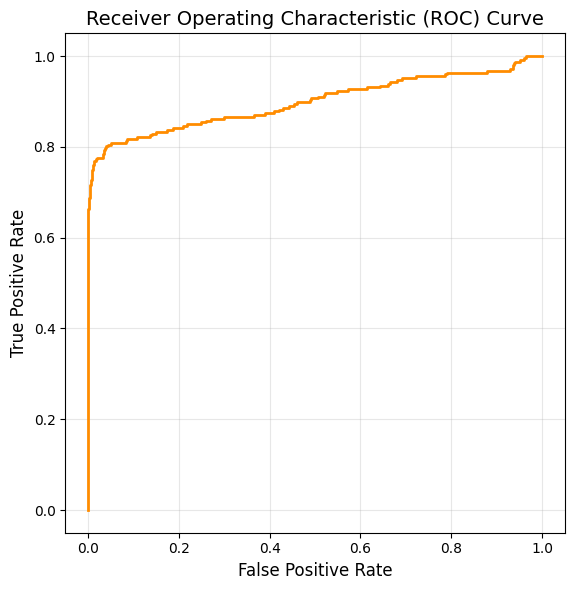

In [22]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('artifacts/figures/ROC curve.png')
plt.show()

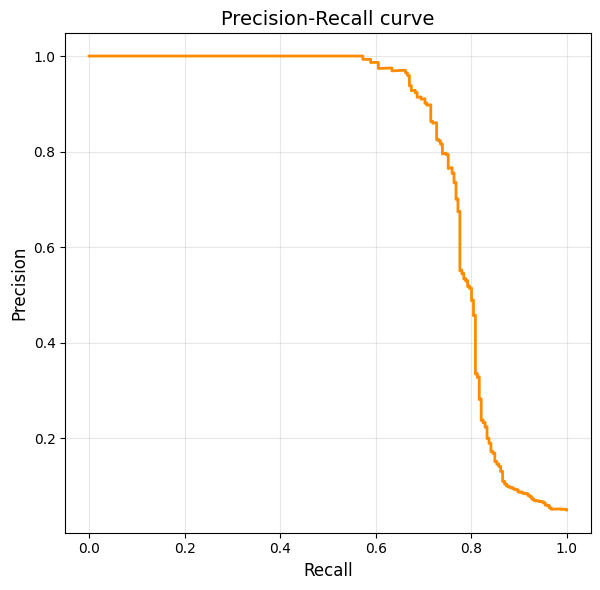

In [23]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='darkorange', lw=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall curve', fontsize=14)
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('artifacts/figures/PR curve.png')
plt.show()

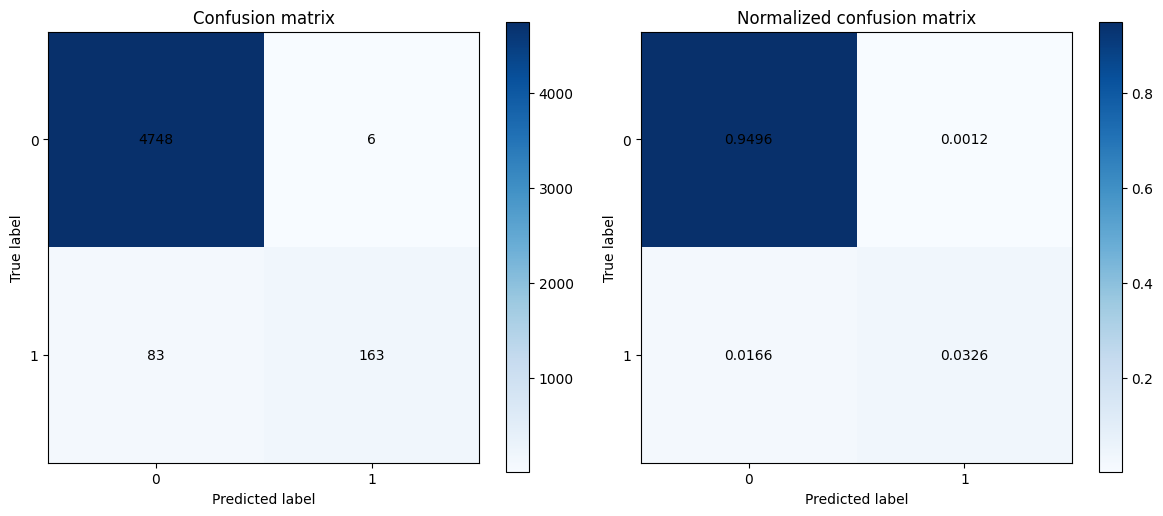

In [24]:
y_pred = best_model.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(y_test, y_pred)
im = ax[0].imshow(cm, cmap='Blues')

ax[0].set_xticks(np.arange(cm.shape[1]))
ax[0].set_yticks(np.arange(cm.shape[0]))
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('Confusion matrix')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, cm[i, j], ha='center', va='center')

cm_norm = confusion_matrix(y_test, y_pred, normalize='all')  
im_norm = ax[1].imshow(cm_norm, cmap='Blues')

ax[1].set_xticks(np.arange(cm_norm.shape[1]))
ax[1].set_yticks(np.arange(cm_norm.shape[0]))
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('Normalized confusion matrix')

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax[1].text(j, i, cm_norm[i, j], ha='center', va='center')

fig.colorbar(im)
fig.colorbar(im_norm)
plt.tight_layout()
plt.savefig('artifacts/figures/confusion matrixes.png')
plt.show()

На нормализованной матрице ошибок видно, что модель правильно угадывает целых 3.26% объектов положительного класса. Учитывая, что изначально положительных примеров всего лишь почти 5%, это неплохой результат.


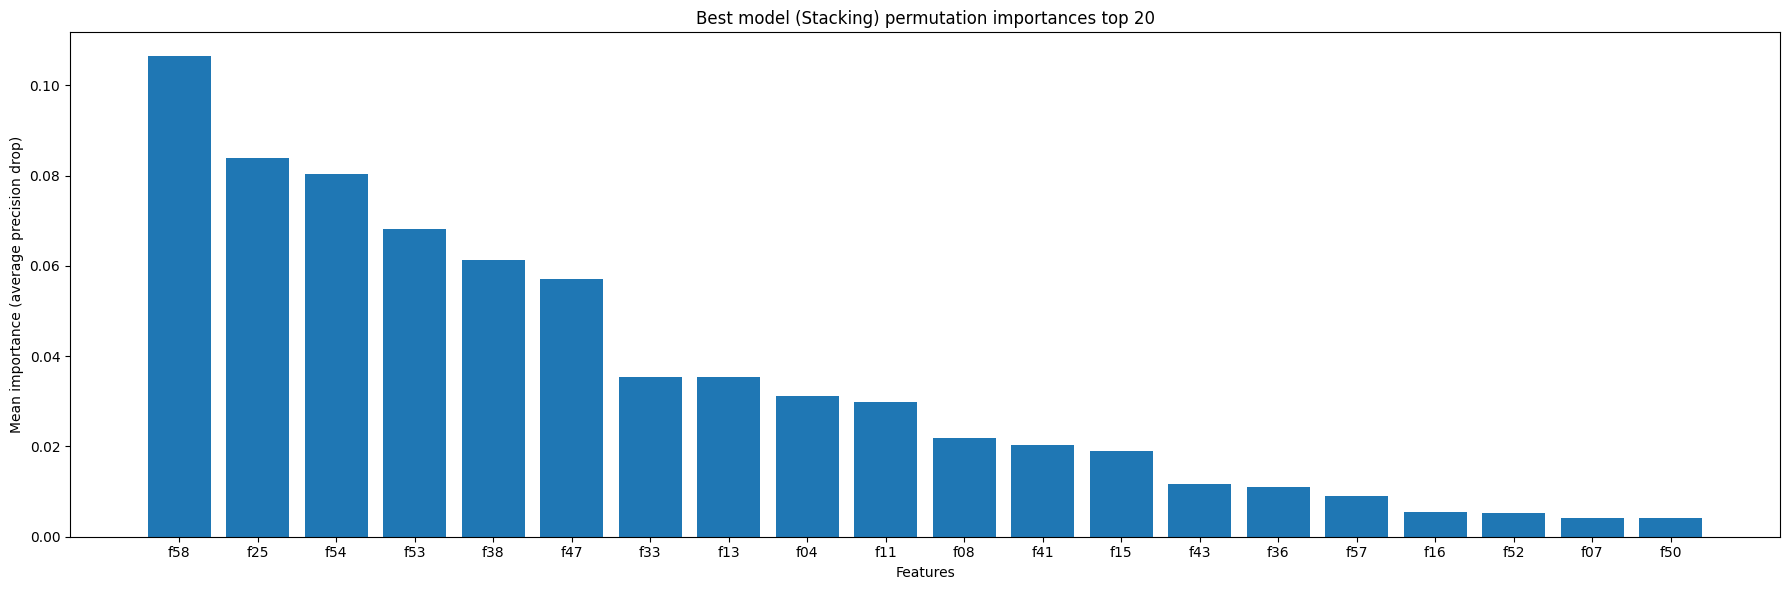

In [25]:
importances = permutation_importance(best_model, X_test, y_test, scoring='average_precision', random_state=random_state)
imps = pd.DataFrame({'columns': df.columns[1: -1], 'importances': importances['importances_mean']})
imps_sorted = imps.sort_values(by='importances', ascending=False).iloc[:20]
plt.figure(figsize=(18, 6))
plt.bar(imps_sorted['columns'], imps_sorted['importances'])
plt.title('Best model (Stacking) permutation importances top 20')
plt.xlabel('Features')
plt.ylabel('Mean importance (average precision drop)')
plt.tight_layout()
plt.show()

In [32]:
plt.savefig('artifacts/figures/importances.png')

<Figure size 640x480 with 0 Axes>

Все графики сохранены в папку artifacts/figures/.

In [33]:
imps_sorted[:15]

,columns,importances
57,f58,0.106396
24,f25,0.083777
53,f54,0.080434
52,f53,0.068162
37,f38,0.061360
46,f47,0.056999
32,f33,0.035464
12,f13,0.035368
3,f04,0.031108
10,f11,0.029786


Далее было решено попробовать откалибровать лучшую модель.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
estimators = [
    ('lr', Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(**{k.replace('lr__', ''): v for k,v in search_summaries['LogisticRegression']['best_params'].items()}, max_iter=7000, random_state=random_state))
    ])),
    ('rf', RandomForestClassifier(**search_summaries['RandomForestClassifier']['best_params'], random_state=random_state)),
    ('hgb', HistGradientBoostingClassifier(**search_summaries['HistGradientBoostingClassifier']['best_params'], random_state=random_state))
]

stack_cal = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=random_state),
    cv=cv,
    n_jobs=-1,
    passthrough=False
    )

calibrated_best = CalibratedClassifierCV(
    estimator=stack_cal,
    method='sigmoid',
    cv=cv,
    n_jobs=-1
)

calibrated_best.fit(X_train, y_train)

y_prob_cal = calibrated_best.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test,
    y_prob_cal,
    n_bins=10
)

frac_uncal, mean_uncal = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(8,8))
plt.plot(mean_uncal, frac_uncal, "s-", label="Uncalibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrated")
plt.plot([0,1],[0,1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
cal_metrics = compute_metrics(calibrated_best, X_test, y_test)
display(cal_metrics)
best_row.to_dict()

{'model': 'CalibratedClassifierCV',
 'accuracy': 0.9816,
 'precision': 0.9476744186046512,
 'recall': 0.6626016260162602,
 'f1-score': 0.7799043062200957,
 'roc auc': 0.9000208639023706,
 'average precision': 0.7948078373053247}

{'model': 'StackingClassifier',
 'accuracy': 0.9822,
 'precision': 0.9644970414201184,
 'recall': 0.6626016260162602,
 'f1-score': 0.7855421686746988,
 'roc auc': 0.8991315828177214,
 'average precision': 0.7961575154623175}

Хотя график откалиброванной модели стал немного плавнее, метрики (кроме roc auc) больше не стали, а даже уменьшились. Но изменения все равно незначительны, думаю, это связано с тем, что изначально у стекинга метамодель - логистическая регрессия, следовательно, вероятности и так были откалиброванны неплохо.

Сохранение лучшей модели и информации о ней.

In [29]:
joblib.dump(best_model, 'artifacts/best_model.joblib')

meta = {
    'best_model_label': best_label,
    'test_metrics': best_row.to_dict(),
    'search_summary': search_summaries.get(best_label, None),
    'random_state': random_state,
}

with open('artifacts/best_model_meta.json', 'w') as best_model_meta:
    json.dump(meta, best_model_meta, ensure_ascii=False, indent=2)